# Procesamiento y Limpieza SECOP I

En este notebook de código se desarrollan los códigos para procesar, limpiar y calcular indicadores de riesgo y banderas rojas en contratación pública a partir de los datos abiertos del SECOP I.

In [1]:
# Cargar librerias para limpieza y procesamiento de datos
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os
import altair as alt
pd.set_option('display.max_columns', None)

In [107]:
# Cargar datos de compras y suministros
suministro = pd.read_csv("Datos/div_secop_i_Suministro.gz")
compraventa = pd.read_csv("Datos/div_secop_i_Compraventa.gz")
compras = pd.concat([suministro,compraventa], axis=0)
del [compraventa, suministro]
compras.head()

,id_contrato,anno_cargue,anno_firma,nivel_entidad,orden_entidad,nombre_entidad,nit_entidad,tipo_proceso,estado_contrato,causa_otras_formas_contr_directa,regimen_contratacion,objeto_contratar,detalle_objeto_contratar,tipo_contrato,fecha_cargue_secop,id_proceso,numero_proceso,numero_contrato,cuantia_proceso,nombre_grupo,nombre_familia,nombre_clase,tipo_id_contratista,id_contratista,razon_social_contratista,dpto_mcpo_contratista,tipo_doc_representate_legal,id_representante_legal,nombre_representante_legal,fecha_firma_contrato,fecha_inicio_ejec_contrato,plazo_ejec_contrato,rango_ejec_contrato,tiempo_adiciones_dias,tiempo_adiciones_meses,fecha_fin_ejec_contrato,cuantia_contrato,valor_adiciones,ruta_web,moneda,municipio_entidad,departamento_entidad,dep_codigo_divipola,municipio_codigo_divipola
0,15-4-4284454-3950808,2015,2015.0,TERRITORIAL,TERRITORIAL DEPARTAMENTAL CENTRALIZADO,VALLE DEL CAUCA - INSTITUCIÓN EDUCATIVA TÉCNIC...,815004298,Régimen Especial,Liquidado,Ninguna,Régimen Especial,"Equipos, Suministros y Accesorios para Deporte...",¿suministro de material deportivo para las pra...,Suministro,10/06/2015,15-4-4284454,1151.20.3. 008,1151.20.3. 008,6000000,[E] Productos de Uso Final,Equipo y accesorios para deportes,Accesorios para deporte,Nit de Persona Jurídica,891303520-2,ALMACEN OLIMPICO LTDA. (JOSE ADULCARIN LANCHER...,Valle del Cauca,Nit de Persona Jurídica,891303520-2,JOSE ADULCARIN LANCHEROS,07/17/2015,07/17/2015,10,D,0,0,07/27/2015,6000000,0,https://www.contratos.gov.co/consultas/detalle...,Pesos (COP),PALMIRA,VALLE DEL CAUCA,76000,76520
1,19-4-8985563-8173742,2019,2018.0,TERRITORIAL,TERRITORIAL DISTRITAL MUNICIPAL NIVEL 2,BOYACÁ - E.S.E. CENTRO DE SALUD SAN RAFAEL,820003782,Régimen Especial,Celebrado,Ninguna,Régimen Especial,Difusión de Tecnologías de Información y Telec...,suministro de equipo de computo portatil para ...,Suministro,02/06/2019,19-4-8985563,057,057,3600000,[E] Productos de Uso Final,Equipo informático y accesorios,Computadores,Nit de Persona Natural,800234910,ASOCIACION BECERRA CASTRO Y COMPAÑIA LIMITADA,Boyacá,Cédula de Ciudadanía,7220435,ALFONSO BECERRA SANTAMARIA,11/01/2018,11/01/2018,15,D,0,0,11/16/2018,3558100,0,https://www.contratos.gov.co/consultas/detalle...,Pesos (COP),UMBITA,BOYACÁ,15000,15842
2,19-13-9465604-8636766,2019,2019.0,TERRITORIAL,TERRITORIAL DISTRITAL MUNICIPAL NIVEL 5,ANTIOQUIA - ALCALDÍA MUNICIPIO DE NECHÍ,800100134-1,Contratación Mínima Cuantía,Celebrado,Ninguna,Estatuto General de Contratación,"Ropa, Maletas y Productos de Aseo Personal",suministro de implementos deportivos para el b...,Suministro,05/28/2019,19-13-9465604,SEMIC-031-2019,CSMC-006-2019,23179800,[E] Productos de Uso Final,Ropa,Uniformes,Nit de Persona Natural,78110240,HERNAN DE JESUS OVIEDO RODELO/ALMACEN BUEN SUE...,Antioquia,Cédula de Ciudadanía,78110240,HERNAN DE JESUS OVIEDO RODELO,06/04/2019,06/05/2019,15,D,0,0,06/20/2019,23179800,0,https://www.contratos.gov.co/consultas/detalle...,Pesos (COP),NECHÍ,ANTIOQUIA,5000,5495
3,19-13-9375191-8561989,2019,2019.0,TERRITORIAL,TERRITORIAL DISTRITAL MUNICIPAL NIVEL 6,BOYACÁ - ALCALDÍA MUNICIPIO DE RAQUIRA,891801280-6,Contratación Mínima Cuantía,Celebrado,Ninguna,Estatuto General de Contratación,"Instrumentos Musicales, Juegos, Artes, Artesan...",suministro de refrigerios y materiales para la...,Suministro,05/07/2019,19-13-9375191,020 de 2019_Mínima Cuantía,017 de 2019_Suministro,14000000,[E] Productos de Uso Final,"Equipo, accesorios y suministros de arte y man...","Utensilios de dibujo, suministros y accesorios",Nit de Persona Jurídica,900695457,LA UNIVERSAL DE INVERSIONES BOYACÁ S.A.S.,Boyacá,Cédula de Ciudadanía,1053343675,KAREN YURLEY VILLAMIL PINILLA,05/13/2019,05/13/2019,4,D,0,0,05/17/2019,13999800,0,https://www.contratos.gov.co/consultas/detalle...,Pesos (COP),RÁQUIRA,BOYACÁ,15000,15600
4,14-13-3004474-2831748,2014,2014.0,TERRITORIAL,TERRITORIAL DISTRITAL MUNICIPAL NIVEL 5,CUNDINAMARCA - ALCALDÍA MUNICIPIO DE LA MESA,890802795-3,Contratación Mínima Cuantía,Liquidad

In [108]:
# Extraer información general de la base de datos de contratos de compra
compras.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1265987 entries, 0 to 351052
Data columns (total 44 columns):
 #   Column                            Non-Null Count    Dtype  
---  ------                            --------------    -----  
 0   id_contrato                       1265987 non-null  object 
 1   anno_cargue                       1265987 non-null  int64  
 2   anno_firma                        1265987 non-null  float64
 3   nivel_entidad                     1265987 non-null  object 
 4   orden_entidad                     1265987 non-null  object 
 5   nombre_entidad                    1265987 non-null  object 
 6   nit_entidad                       1265987 non-null  object 
 7   tipo_proceso                      1265987 non-null  object 
 8   estado_contrato                   1265987 non-null  object 
 9   causa_otras_formas_contr_directa  1265987 non-null  object 
 10  regimen_contratacion              1265987 non-null  object 
 11  objeto_contratar                  1265

# Limpieza, Procesamiento y Filtrado de datos

A continuación se describen algunas tareas pendientes de limpieza de datos.

* [ ] Corregir los valores extremos y contratos de valor cero. Utilizar los algoritmos y datos de la consultoría DAPRE.
* [ ] Limpiear el nit de los contratistas y las entidades.
* [X] Estandarizar algunas variables como tipo de proceso, nivel y orden de la entidad, entre otros.
* [X] Unificar la duración del contrato.
* [X] Revisar y ajustar contratos con valor en dolares.
* [ ] Agregar variables de minima cuantia y menor cuantia para cada entidad

## Filtro de Contratos por cuantía

Se aplica el siguiente filtro:

- Contratos de mas de 100 millones.
- Entidades con mínimo 5 contratos.

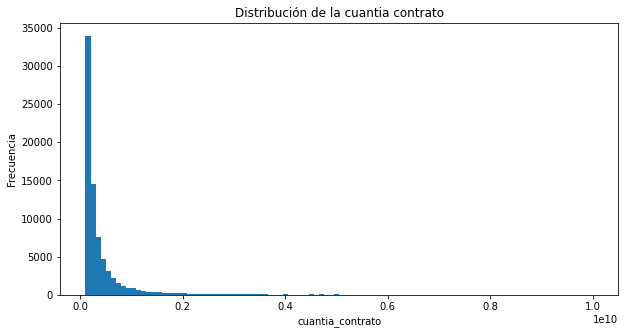

In [109]:
# Histogram for cuantia_contrato
plt.figure(figsize=(10,5))
plt.hist(compras.loc[(compras['cuantia_contrato'] > 1e8) & (compras['cuantia_contrato'] < 1e10), ['cuantia_contrato']], bins=100)
plt.title('Distribución de la cuantia contrato')
plt.xlabel('cuantia_contrato')
plt.ylabel('Frecuencia')
plt.show()

In [110]:
# Número de contratos por menos de 100 millones
sum(compras['cuantia_contrato'] < 1e8)

1185404

In [111]:
# Número de contratos por mas de 100 mil millones
sum(compras['cuantia_proceso'] > 1e11)

232

In [112]:
# Seleccionar contratos de una cuantia mínima
min_valor = 1e8 # Mas de 100 millones
max_valor = 1e11 # Menos de 100,000 millones
compras = compras.loc[((compras["cuantia_contrato"] >= min_valor) | 
                       (compras["cuantia_proceso"] >= min_valor) | 
                       (compras["valor_adiciones"] >= min_valor)) 
                      & (compras["cuantia_contrato"] <= max_valor)]
print("Hay {:,} contratos de mínimo ${:,.0f} y de máximo ${:,.0f}".format(compras.shape[0], min_valor, max_valor))

Hay 94,910 contratos de mínimo $100,000,000 y de máximo $100,000,000,000


## Filtrado de entidades por número mínimo de contratos

In [113]:
# Incluir entidades con mínimo 5 contratos
min_contratos = 5
temp = compras.groupby('nombre_entidad').size().reset_index().rename({0:'n_contratos'}, axis=1)
temp = temp.loc[temp['n_contratos'] >= min_contratos]
print("Hay {} entidades con mínimo {} contratos".format(temp.shape[0], min_contratos))

# Filtrar entidades con la minima cantidad de contratos requeridas
compras = compras.loc[compras["nombre_entidad"].isin(temp["nombre_entidad"])]
del temp

Hay 1767 entidades con mínimo 5 contratos


In [114]:
print('Filtrando entidades con mínimo {} contratos nos quedan {:,.0f} registros'.format(min_contratos, compras.shape[0]))

Filtrando entidades con mínimo 5 contratos nos quedan 92,897 registros


In [115]:
# Numero de entidades
compras['nombre_entidad'].nunique()

1767

## Estandarización del tipo de proceso

In [116]:
# Tipo de proceso
compras.value_counts(['tipo_proceso'])

tipo_proceso                                                                         
Subasta                                                                                  29554
Régimen Especial                                                                         29533
Selección Abreviada de Menor Cuantía (Ley 1150 de 2007)                                  16044
Contratación Directa (Ley 1150 de 2007)                                                   9020
Licitación Pública                                                                        7448
Contratación Mínima Cuantía                                                                937
Selección Abreviada del literal h del numeral 2 del artículo 2 de la Ley 1150 de 2007      152
Selección Abreviada servicios de Salud                                                     125
Licitación obra pública                                                                     46
Contratos y convenios con más de dos partes                

In [117]:
# Estandarización del tipo de proceso
map_tipo_proceso = {
    "Concurso de Méritos Abierto": "concurso_meritos", 
    "Concurso de Méritos con Lista Corta": "concurso_meritos", 
    "Concurso de Méritos con Lista Multiusos": "concurso_meritos",
    "Contratación Directa (Ley 1150 de 2007)":"contratacion_directa",
    "Contratación Directa (con ofertas)":"contratacion_directa",
    "Contratación directa":"contratacion_directa",
    "Contratación Mínima Cuantía":"minima_cuantia",
    "Mínima cuantía":"minima_cuantia",
    "Licitación Pública":"licitacion_publica",
    "Licitación obra pública":"licitacion_publica", 
    "Licitación pública":"licitacion_publica",
    "Régimen Especial":"regimen_especial",
    "Contratación régimen especial":"regimen_especial",
    "Contratación régimen especial (con ofertas)":"regimen_especial",
    "Selección Abreviada de Menor Cuantía (Ley 1150 de 2007)":"seleccion_abreviada",
    "Selección Abreviada del literal h del numeral 2 del artículo 2 de la Ley 1150 de 2007":"seleccion_abreviada",
    "Selección Abreviada servicios de Salud":"seleccion_abreviada",
    "Seleccion Abreviada Menor Cuantia Sin Manifestacion Interes":"seleccion_abreviada",
    "Selección Abreviada de Menor Cuantía":"seleccion_abreviada",
    "Selección abreviada subasta inversa":"seleccion_abreviada",
    "Subasta":"subasta",
    "Contratos y convenios con más de dos partes":"otros",
    "Asociación Público Privada":"otros"
}
compras["tipo_proceso"].replace(to_replace=map_tipo_proceso, inplace=True)
compras.groupby("tipo_proceso").size().sort_values(ascending=False)

tipo_proceso
subasta                 29554
regimen_especial        29533
seleccion_abreviada     16321
contratacion_directa     9020
licitacion_publica       7494
minima_cuantia            937
concurso_meritos           19
otros                      19
dtype: int64

## Estadarización del nivel de entidad

In [118]:
# Estandarización para el nivel de la entidad
map_nivel_entidad = {
    "NACIONAL":"nacional",
    "TERRITORIAL":"territorial",
    "No Definida":"no_definida"
}
compras["nivel_entidad"].replace(to_replace=map_nivel_entidad, inplace=True)
compras.groupby("nivel_entidad").size().sort_values(ascending=False)

nivel_entidad
territorial    57001
nacional       35896
dtype: int64

In [119]:
# Verificar si la entidad tiene registrado mas de un nivel
print("Hay {} entidades con mas de un nivel de entidad registrado".format(sum(compras.groupby("nombre_entidad")["nivel_entidad"].nunique() > 1)))

Hay 0 entidades con mas de un nivel de entidad registrado


## Estadarización de las categorías para el orden de la entidad

In [120]:
# Redefinir las categorias para el orden de entidad
map_orden_entidad = {
    "DISTRITO CAPITAL": "distr_capital",
    "NACIONAL CENTRALIZADO": "nac_centralizado",
    "NACIONAL DESCENTRALIZADO":"nac_descentralizado",
    "TERRITORIAL DEPARTAMENTAL CENTRALIZADO": "terri_dep_centr",
    "TERRITORIAL DEPARTAMENTAL DESCENTRALIZADO": "terri_dep_no_centr",
    "TERRITORIAL DISTRITAL MUNICIPAL NIVEL 1": "terri_distr_1",
    "TERRITORIAL DISTRITAL MUNICIPAL NIVEL 2": "terri_distr_2",
    "TERRITORIAL DISTRITAL MUNICIPAL NIVEL 3": "terri_distr_3",
    "TERRITORIAL DISTRITAL MUNICIPAL NIVEL 4": "terri_distr_4",
    "TERRITORIAL DISTRITAL MUNICIPAL NIVEL 5": "terri_distr_5",
    "TERRITORIAL DISTRITAL MUNICIPAL NIVEL 6": "terri_distr_6",
    "No Definido": "no_defindo"
}

compras["orden_entidad"].replace(to_replace=map_orden_entidad, inplace=True)
print(compras.groupby("orden_entidad").size().sort_values(ascending=False))

# Verificar si la entidad tiene registrado mas de un orden de entidad
print("Hay {} entidades con mas de un orden de entidad registrado".format(sum(compras.groupby("nombre_entidad")["orden_entidad"].nunique() > 1)))

orden_entidad
nac_centralizado       21146
terri_dep_no_centr     18246
nac_descentralizado    15037
terri_distr_6          10422
terri_distr_2           6890
terri_dep_centr         6570
terri_distr_1           6480
distr_capital           2645
terri_distr_4           2560
terri_distr_5           1935
terri_distr_3            966
dtype: int64
Hay 2 entidades con mas de un orden de entidad registrado


In [121]:
# Asignar orden de entidad con mayor frecuencia
# Activar procesamiento de orden de entidad
asignar_orden = False
if asignar_orden:
    temp = compras.groupby("nombre_entidad")["orden_entidad"].nunique()
    temp = temp[temp > 1]
    temp2 = compras.loc[compras["nombre_entidad"].isin(temp.index)].groupby(["nombre_entidad","orden_entidad"]).size().reset_index().rename({0:"n"}, axis=1)

    def sel_orden(groups):
        n_orden = groups.sort_values(by = "n", ascending = False)
        orden = n_orden["orden_entidad"][0:1]
        return orden

    temp3 = temp2.groupby("nombre_entidad").apply(sel_orden).reset_index()

    for i in range(temp3.shape[0]):
        compras.loc[compras["nombre_entidad"] == temp3["nombre_entidad"][i], ["orden_entidad"]] = temp3["orden_entidad"][i]
        
    del [temp, temp2, temp3]

    # Verificar si la entidad tiene registrado mas de un nivel
    print("Hay {} entidades con mas de un orden de entidad registrado".format(sum(compras.groupby("nombre_entidad")["nivel_entidad"].nunique() > 1)))


## Ajustar departamento de entidad

In [122]:
# Ajustar el nombre del departamento de la entidad
compras["departamento_entidad"] = compras["departamento_entidad"].str.lower().str.replace(" ","-")

# Verificar si una entidad tiene mas de un departamento registrado
sum(compras.groupby("nombre_entidad")["departamento_entidad"].nunique() > 1)

0

## Estandarización del regimen de contratación

In [123]:
# Estadarización del regimen de contratación
map_regimen = {
    "Estatuto General de Contratación":"general",
    "Ley 80 de 1993": "general",
    "Régimen Especial": "especial"
}

compras["regimen_contratacion"].replace(to_replace=map_regimen, inplace=True)
compras["regimen_contratacion"].value_counts()


general     62271
especial    30626
Name: regimen_contratacion, dtype: int64

## Limpieza del id del contratista

In [124]:
#Limpieza rapida del id del contratista
def find_number(text):
    num = re.findall(r'[0-9]+',text)
    return " ".join(num)
#
compras["id_contratista"] = compras["id_contratista"].apply(str)
compras['id_contratista_mod'] = compras["id_contratista"].apply(lambda x: find_number(x))
compras['id_contratista_mod'] = compras["id_contratista"].str.replace(pat=r'\D', repl='')
print("La limpieza genera una reducción de {:,} contratistas unicos".format(len(np.unique(compras["id_contratista"])) - len(np.unique(compras["id_contratista_mod"]))))

/var/folders/yb/73r2f0hj06z2_w4y40669q480000gn/T/ipykernel_802/657578935.py:8: FutureWarning: The default value of regex will change from True to False in a future version.
  compras['id_contratista_mod'] = compras["id_contratista"].str.replace(pat=r'\D', repl='')


La limpieza genera una reducción de 6,962 contratistas unicos


In [125]:
# Numero de contratistas
compras['id_contratista_mod'].nunique()

28634

## Revisar duplicados

In [126]:
# Revisar duplicados
sum(compras.duplicated())

0

## Guardar base de datos de compras

In [127]:
guardar_compras = False
if guardar_compras:
    compras.to_csv('Datos/compras.csv.gz', index=False)

# Indicadores de riesgo de corrupción a nivel de entidad

En esta segunda parte del notebook se calculan y analizan de forma exploratoria algunos indicadores de riesgo a nivel de entidad

## Porcentaje de contratación directa

Mide el porcentaje de contratos que la entidad realiza bajo la modalidad de contratación directa. Este porcentaje se puede calcular con respecto al numero de contratos o al valor de los contratos:

$$
\text{Contratación Directa} = \frac{\text{Cantidad de Contratación Directa de la Entidad}}{\text{Total de Contratación de la Entidad}} \times 100
$$

Donde, 

- La *cantidad de contratación directa* puede ser el numero de contratos o el valor total contratación ejecutado por la entidad bajo esta modalidad.
- El *total de la contratación* puede ser el numero de contratos total o el valor total de la contratación de cada entidad.

In [2]:
compras = pd.read_csv('Datos/compras.csv.gz')

In [3]:
# Funcion para integrar las bases de datos temporales "temp"
def integrar():
    df = pd.merge(left=ind_entidad, right=temp, on='nombre_entidad', how="left")
    return(df)

In [4]:
# Numero de contratos por entidad
ind_entidad = compras.groupby('nombre_entidad').size().reset_index().rename({0:'ind_ent_ncontratos'}, axis=1)

In [5]:
# Crear una columna para indicar si el proceso se hizo por contratación directa
compras["contratacion_directa"] = np.where(compras["tipo_proceso"] == "contratacion_directa", 1, 0)

# Calcula el porcentaje de contratos que se hicieron de forma directa por cada entidad
temp = compras.groupby("nombre_entidad")["contratacion_directa"]\
    .mean()\
    .reset_index()\
    .rename({"contratacion_directa":"ind_ent_pcontr_directa_num"}, axis=1)

ind_entidad = integrar()

In [6]:
# Valor total de por entidad
temp = compras.groupby("nombre_entidad")["cuantia_contrato"]\
    .sum()\
    .reset_index()\
    .rename({"cuantia_contrato":"ind_ent_val_contratos"}, axis=1)
ind_entidad = integrar()

# Cuantia total de la contratación directa por entidad
temp = compras.loc[compras["contratacion_directa"] == 1, ["nombre_entidad","cuantia_contrato"]]\
    .groupby("nombre_entidad")["cuantia_contrato"]\
    .sum()\
    .reset_index()\
    .rename({"cuantia_contrato":"cuantia_contratacion_directa"}, axis=1)
ind_entidad = integrar()

# Rellena valores faltantes con cero
ind_entidad["cuantia_contratacion_directa"].fillna(0, inplace=True)

# Calcula el porcentaje contratación directa.
ind_entidad["ind_ent_pcontr_directa_val"] = ind_entidad["cuantia_contratacion_directa"]/ind_entidad["ind_ent_val_contratos"]
ind_entidad.drop(columns=["cuantia_contratacion_directa"], inplace=True)

In [7]:
ind_entidad.head(10)

,nombre_entidad,ind_ent_ncontratos,ind_ent_pcontr_directa_num,ind_ent_val_contratos,ind_ent_pcontr_directa_val
0,ADMINISTRADORA COLOMBIANA DE PENSIONES (COLPEN...,44,0.000000,212207960851,0.000000
1,AERONÁUTICA CIVIL (AEROCIVIL),332,0.054217,665733414599,0.058042
2,AGENCIA DE DESARROLLO RURAL - ADR,5,0.200000,1542332558,0.100906
3,AGENCIA DE RENOVACION DEL TERRITORIO,37,0.189189,22365554248,0.612546
4,AGENCIA DEL INSPECTOR GENERAL DE TRIBUTOS REN...,16,0.250000,5376587591,0.420208
5,AGENCIA LOGÍSTICA DE LAS FUERZAS MILITARES (ALFM),1667,0.019196,822315307271,0.017424
6,AGENCIA NACIONAL DE DEFENSA JURÍDICA DEL ESTAD...,5,0.000000,1121170000,0.000000
7,AGENCIA NACIONAL DE HIDROCARBUROS (ANH),35,0.028571,34008152958,0.005293
8,AGENCIA NACIONAL DE INFRAESTRUCTURA (ANI),38,0.052632,14890239441,0.038461
9,AGENCIA NACIONAL DE MINERÍA (ANM),90,0.144444,63162176466,0.095208


In [8]:
# Diferencia entre los dos indicadores de contratación directa
ind_entidad["ind_ent_dif_pcontr_directa"] = ind_entidad["ind_ent_pcontr_directa_num"] - ind_entidad["ind_ent_pcontr_directa_val"]

In [9]:
ind_entidad[['ind_ent_pcontr_directa_num','ind_ent_pcontr_directa_val','ind_ent_dif_pcontr_directa']].describe()

,ind_ent_pcontr_directa_num,ind_ent_pcontr_directa_val,ind_ent_dif_pcontr_directa
count,1767.000000,1767.000000,1767.000000
mean,0.132414,0.142716,-0.010302
std,0.221220,0.238960,0.094833
min,0.000000,0.000000,-0.746842
25%,0.000000,0.000000,0.000000
50%,0.038710,0.021612,0.000000
75%,0.166667,0.174456,0.007073
max,1.000000,1.000000,0.685955


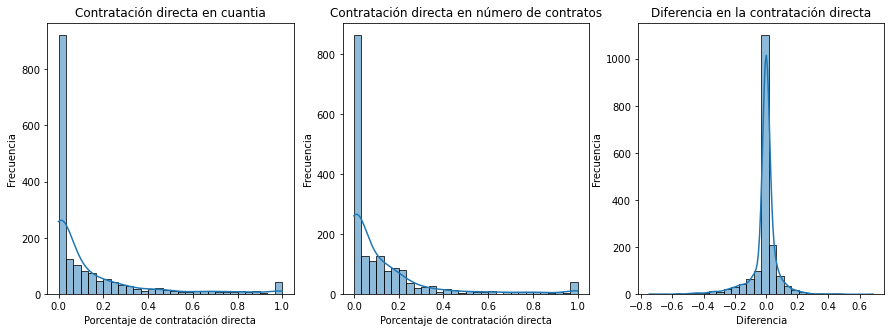

In [10]:
# Analizar la distribución del porcentaje de contratación directa en valor y cantidad de contratos y la diferencia entre estos dos indicadores por entidad
fig, ((ax1,ax2,ax3)) = plt.subplots(ncols=3, figsize=(15,5))

sns.histplot(data=ind_entidad, x="ind_ent_pcontr_directa_val", bins=30, kde=True, ax=ax1)
ax1.set_title("Contratación directa en cuantia")
ax1.set_xlabel("Porcentaje de contratación directa")
ax1.set_ylabel("Frecuencia")

sns.histplot(data=ind_entidad, x="ind_ent_pcontr_directa_num", bins=30, kde=True, ax=ax2)
ax2.set_title("Contratación directa en número de contratos")
ax2.set_xlabel("Porcentaje de contratación directa")
ax2.set_ylabel("Frecuencia")

sns.histplot(data=ind_entidad, x="ind_ent_dif_pcontr_directa", bins=30, kde=True, ax=ax3)
ax3.set_title("Diferencia en la contratación directa")
ax3.set_xlabel("Diferencia")
ax3.set_ylabel("Frecuencia")

#fig.savefig('plots/ind_ent_contr_directa.png')

plt.show()

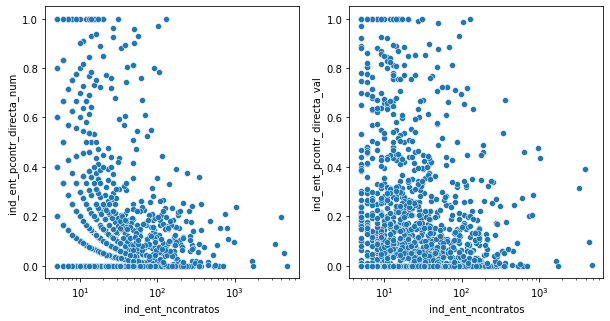

In [11]:
# Relación entre el porcentaje de contratación directa y el numero de contratos
fig, ((ax1,ax2)) = plt.subplots(ncols=2, figsize=(10,5), sharex=True)
sns.scatterplot(data=ind_entidad, x='ind_ent_ncontratos', y='ind_ent_pcontr_directa_num', ax=ax1)
ax1.set_xscale('log')
sns.scatterplot(data=ind_entidad, x='ind_ent_ncontratos', y='ind_ent_pcontr_directa_val', ax=ax2)
plt.show()

## Indice de concentración de contratos HHI

El índice *Herfindahl*, también conocido como Índice *Herfindahl-Hirschman* o *HHI*, es una medida del tamaño de las empresas en relación con la industria y un indicador de la cantidad de competencia entre ellas. Se calcula como la suma de los cuadrados de las cuotas de mercado de las empresas dentro de la industria (a veces limitada a las 50 empresas más grandes).

$$
HHI = \sum_{i=1}^{n}s_{i}^2
$$

Donde, $s_i$ es la cuota de mercado de la empresa $i$ expresada en porcentaje. Tiendo en cuenta que el indicador esta en un rango de [0,10000], se estandariza el indicador dividiendo el HHI entre 10000.

In [12]:
# Función para calcular el HHI por entidad
def compute_hhi(df):
    total = df['total'].sum()
    hhi_elements = [((value/total)*100)**2 for value in df['total']]
    #top_3_amts = buyer_month['Amount'].order(ascending = False)[0:3]
    hhi = sum(hhi_elements)
    return hhi

In [13]:
# Calcula el HHI en numero de contratos
entidad_contratista = (
    compras
    .groupby(["nombre_entidad",'id_contratista'])
    .size()
    .reset_index()
    .rename({0:"total"}, axis=1))

temp = (
    entidad_contratista
    .groupby("nombre_entidad")
    .apply(compute_hhi)
    .reset_index()
    .rename({0:"ind_ent_HHI_num"}, axis=1))

ind_entidad = integrar()

In [14]:
# Calcula el HHI en cuantia de contratos
entidad_contratista = (
    compras
    .groupby(["nombre_entidad",'id_contratista'])["cuantia_contrato"]
    .sum()
    .reset_index()
    .rename({"cuantia_contrato":"total"}, axis=1))

temp = (
    entidad_contratista
    .groupby("nombre_entidad")
    .apply(compute_hhi)
    .reset_index()
    .rename({0:"ind_ent_HHI_val"}, axis=1))

ind_entidad = integrar()

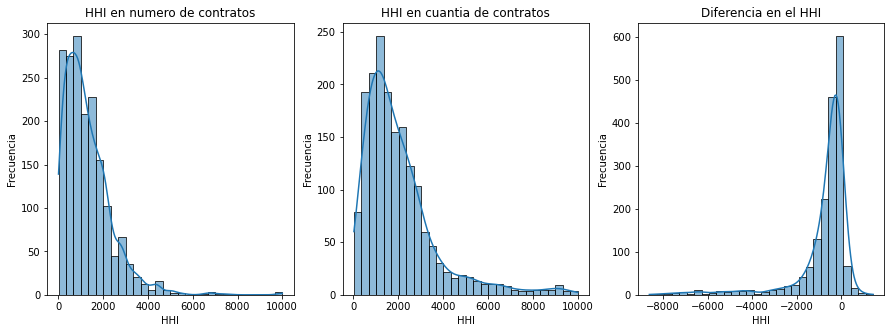

In [15]:
# Gráficar la distribución de los indicadores HHI
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(15,5))

sns.histplot(data=ind_entidad, x="ind_ent_HHI_num", bins=30, kde=True, ax=ax1)
ax1.set_title("HHI en numero de contratos")
ax1.set_xlabel("HHI")
ax1.set_ylabel("Frecuencia")

sns.histplot(data=ind_entidad, x="ind_ent_HHI_val", bins=30, kde=True, ax=ax2)
ax2.set_title("HHI en cuantia de contratos")
ax2.set_xlabel("HHI")
ax2.set_ylabel("Frecuencia")

ind_entidad["ind_ent_dif_HHI"] = ind_entidad["ind_ent_HHI_num"] - ind_entidad["ind_ent_HHI_val"]
sns.histplot(data=ind_entidad, x="ind_ent_dif_HHI", bins=30, kde=True, ax=ax3)
ax3.set_title("Diferencia en el HHI")
ax3.set_xlabel("HHI")
ax3.set_ylabel("Frecuencia")

#fig.savefig('plots/ind_ent_HHI')

plt.show()

## Indice de diversidad - ID

El *indice de diversidad de Simpson* (también conocido como el índice de la diversidad de las especies o índice de dominancia) es uno de los parámetros que permiten medir la biodiversidad de organismos en un hábitat. Llevado al contexto de la contratación permite medir la diversidad de contratistas en una entidad. La formula para el indice de Simpson es:

$$
ID = \frac{\sum_{j=1}^{S} n_j (n_j - 1)}{N (N - 1)}
$$
Donde,

- $S$: Numero total de contratistas de una entidad.
- $n_j$: es el numero de contratos adjudicados al contratista $j$.
- $N$: es el numero total los contratos adjudicados por cada entidad.

Cuando el indice es cercano a 1 existe una menor diversidad y por tanto mayor dominancia de algunos contratistas, y cuando es cercano a 0 ocurre lo contrario, existe mayor diversidad y por tanto menor dominancia de algunos contratistas.

In [16]:
# Función para calcular el indice de diversidad
def compute_ID(df):
    total = df['total'].sum()
    ID_elements = [value*(value-1) for value in df['total']]
    #top_3_amts = buyer_month['Amount'].order(ascending = False)[0:3]
    ID = sum(ID_elements)/(total*(total-1))
    return ID

In [17]:
# Calcula el ID en numero de contratos
entidad_contratista = (
    compras
    .groupby(["nombre_entidad",'id_contratista'])
    .size()
    .reset_index()
    .rename({0:"total"}, axis=1))

temp = (
    entidad_contratista
    .groupby("nombre_entidad")
    .apply(compute_ID)
    .reset_index()
    .rename({0:"ind_ent_Idiversidad"}, axis=1))

ind_entidad = integrar()

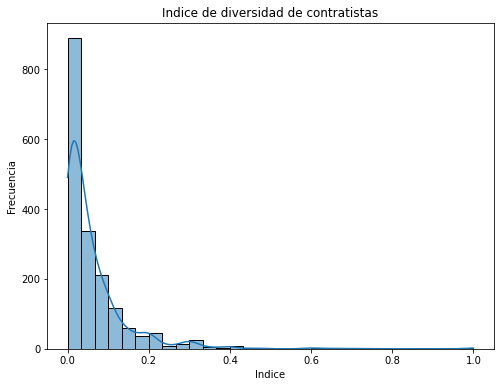

In [18]:
plt.figure(figsize=(8,6))
sns.histplot(data=ind_entidad, x="ind_ent_Idiversidad", bins=30, kde=True)
plt.title("Indice de diversidad de contratistas")
plt.xlabel("Indice")
plt.ylabel("Frecuencia")
#plt.savefig('plots/ind_ent_Idiversidad.png')
plt.show()

## Ratio de contratistas por contrato

Mide el número de empresas diferentes adjudicatarias de los procesos de contratación. Dado que cada entidad tiene un volumen diferente de contratación, el indice se expresó en numero de contratistas por contrato.

$$
\text{Ratio contratistas} = \frac{\text{Número Contratistas Diferentes}}{\text{Total Contratos}}
$$

Entre menor el valor mayor el riesgo.

In [19]:
temp = (
    compras
    .groupby(["nombre_entidad"])['id_contratista']
    .nunique()
    .reset_index()
    .rename({'id_contratista':"ind_entidad_ncontratistas"}, axis=1))

ind_entidad = integrar()

ind_entidad["ind_ent_ratio_contratistas"] = ind_entidad["ind_entidad_ncontratistas"]/ind_entidad["ind_ent_ncontratos"]

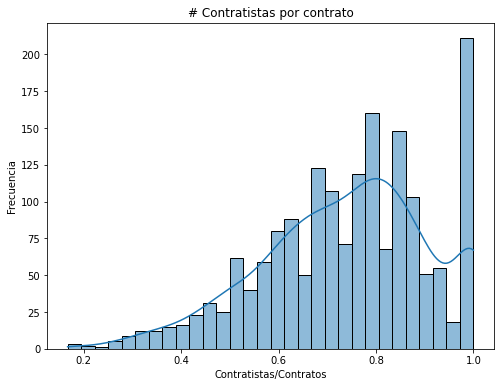

In [20]:
plt.figure(figsize=(8,6))
sns.histplot(data=ind_entidad, x="ind_ent_ratio_contratistas", bins=30, kde=True)
plt.title("# Contratistas por contrato")
plt.xlabel("Contratistas/Contratos")
plt.ylabel("Frecuencia")
#plt.savefig('plots/ind_ent_ratio_contratistas.png')
plt.show()

## Índice de concentración de las cuatro empresas con mayor numero y valor de contratos - IC4k

Mide la proporción de contratos que la entidad estatal adjudicó a los cuatro contratistas con más contratos. Un valor alto indicaría que hay pocos contratistas con muchos contratos.

$$
IC4K = \frac{\sum_{k=1}^{K} n_k}{N}
$$
Donde:

- $k$: representa la posición del k-esimo contratista en numero o valor de contratos.
- $K$: se tomaran los primeros 4 cuatro contratistas.
- $n_k$: es el numero o valor de los contratos del contratista $k$.
- $N$: es el numero o valor total de contratos de la entidad.

In [21]:
# Función para calcular el IC4K
def compute_IC4K(df):
    total = df['total'].sum()
    top_4 = df['total'].sort_values(ascending = False)[0:4]
    #hhi_elements = [((value/total)*100)**2 for value in df['total']]
    
    ICK4 = sum(top_4)/total
    return ICK4

In [22]:
# Calcula el ICK4 en numero de contratos
entidad_contratista = (
    compras
    .groupby(["nombre_entidad",'id_contratista'])
    .size()
    .reset_index()
    .rename({0:"total"}, axis=1)
    )

temp = (
    entidad_contratista
    .groupby("nombre_entidad")
    .apply(compute_IC4K)
    .reset_index()
    .rename({0:"ind_ent_IC4K_num"}, axis=1)
    )

ind_entidad = integrar()

# Calcula el ICK4 en cuantia de contratos
entidad_contratista = (
    compras
    .groupby(["nombre_entidad",'id_contratista'])["cuantia_contrato"]
    .sum()
    .reset_index()
    .rename({"cuantia_contrato":"total"}, axis=1)
    )

temp = (
    entidad_contratista
    .groupby("nombre_entidad")
    .apply(compute_IC4K)
    .reset_index()
    .rename({0:"ind_ent_IC4K_val"}, axis=1)
    )

ind_entidad = integrar()

ind_entidad["dif_IC4K"] = ind_entidad["ind_ent_IC4K_num"] - ind_entidad["ind_ent_IC4K_val"]


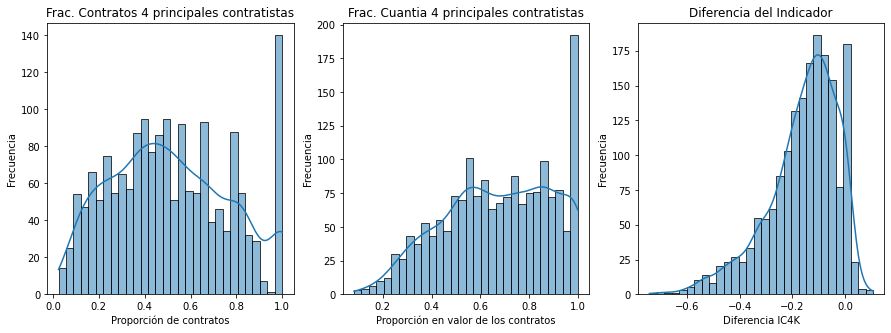

In [23]:
# Gráfica la distribución del IC4K en numero de contratos y valor

fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(15,5))

sns.histplot(data=ind_entidad, x="ind_ent_IC4K_num", bins=30, kde=True, ax=ax1)
ax1.set_title("Frac. Contratos 4 principales contratistas")
ax1.set_xlabel("Proporción de contratos")
ax1.set_ylabel("Frecuencia")

sns.histplot(data=ind_entidad, x="ind_ent_IC4K_val", bins=30, kde=True, ax=ax2)
ax2.set_title("Frac. Cuantia 4 principales contratistas")
ax2.set_xlabel("Proporción en valor de los contratos")
ax2.set_ylabel("Frecuencia")

sns.histplot(data=ind_entidad, x="dif_IC4K", bins=30, kde=True, ax=ax3)
ax3.set_title("Diferencia del Indicador")
ax3.set_xlabel("Diferencia IC4K")
ax3.set_ylabel("Frecuencia")

#fig.savefig('plots/ind_ent_IC4K.png')
plt.show()

## Proporción de contratos con adiciones en tiempo y valor

Mide el porcentaje de contratos que presentan adiciones en tiempo, en valor o en ambos

In [24]:
# Función para calcular el porcentaje de contratos con adiciones en valor
def frac_adiciones_cuantia(df):
    f_adiciones = np.mean(df["valor_adiciones"] > 0)
    return f_adiciones

# Calcular el porcentaje de adiciones en valor
temp = (
    compras
    .groupby("nombre_entidad")
    .apply(frac_adiciones_cuantia)
    .reset_index()
    .rename({0:"ind_ent_padicion_val"}, axis=1)
    )

ind_entidad = integrar()

In [25]:
# Función para calcular el porcentaje de contratos con adiciones en tiempo
def frac_adiciones_tiempo(df):
    f_adiciones = np.mean((df["tiempo_adiciones_dias"] > 0) | (df["tiempo_adiciones_meses"] > 0))
    return f_adiciones

# Calcular el porcentaje de adiciones en tiempo
temp = (
    compras
    .groupby("nombre_entidad")
    .apply(frac_adiciones_tiempo)
    .reset_index()
    .rename({0:"ind_ent_padicion_time"}, axis=1)
    )

ind_entidad = integrar()

In [26]:
# Función para calcular el porcentaje de contratos con adiciones en tiempo y valor
def frac_adiciones_tiempo_valor(df):
    f_adiciones = np.mean((df["valor_adiciones"] > 0) & ((df["tiempo_adiciones_dias"] > 0) | (df["tiempo_adiciones_meses"] > 0)))
    return f_adiciones

# Calcular el porcentaje de adiciones en tiempo y valor
temp = (
    compras
    .groupby("nombre_entidad")
    .apply(frac_adiciones_tiempo_valor)
    .reset_index()
    .rename({0:"ind_ent_padicion_time_val"}, axis=1)
    )

ind_entidad = integrar()

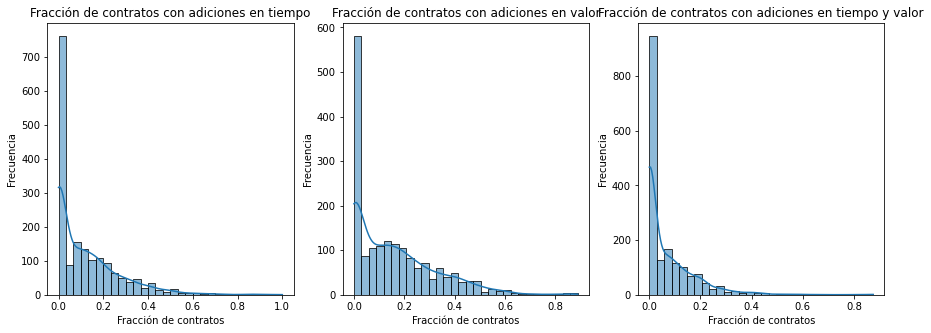

In [27]:
# Revisar la distribución del porcentaje de adiciones por entidad

fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(15,5))
sns.histplot(data=ind_entidad, x="ind_ent_padicion_time", bins=30, kde=True, ax=ax1)
ax1.set_title("Fracción de contratos con adiciones en tiempo")
ax1.set_xlabel("Fracción de contratos")
ax1.set_ylabel("Frecuencia")

sns.histplot(data=ind_entidad, x="ind_ent_padicion_val", bins=30, kde=True, ax=ax2)
ax2.set_title("Fracción de contratos con adiciones en valor")
ax2.set_xlabel("Fracción de contratos")
ax2.set_ylabel("Frecuencia")

ind_entidad["ind_ent_dif_adicion"] = ind_entidad["ind_ent_padicion_time"] - ind_entidad["ind_ent_padicion_val"]

sns.histplot(data=ind_entidad, x="ind_ent_padicion_time_val", bins=30, kde=True, ax=ax3)
ax3.set_title("Fracción de contratos con adiciones en tiempo y valor")
ax3.set_xlabel("Fracción de contratos")
ax3.set_ylabel("Frecuencia")

#fig.savefig('plots/ind_ent_padicion.png')
plt.show()

## Otros indicadores de riesgos

Adicional a los indicadores ya calculados se propone la estructura y estimación de los siguientes indicadores:

- Porcentaje de contratos con adiciones, en tiempo y valor, que super el 50% del valor o duración inicial.
- Porcentaje de contratos firmados con un valor cercano a la mínima cuantia y que luego son adicionados. En este indicador sería interesante revisar los contratos que son firmados.
- Porcentaje de contratos firmados a final de año, de noviembre a febrero.
- Porcentaje de contratos con sanciones o investigaciones por parte de las entidades de control (Procuradoria, Fiscalia, Contraloria, SIC, entre otros.).
- Porcentaje de contratos que no cumplen las restricciones que impone la ley de acuerdo a los valores y tipos de procesos a utilizar.
- Peso en la contratación de contratistas sopechosos.

## Estadísticas de contratación por entidad

In [28]:
# Calcular estadísticas de los contratos a nivel de entidad
temp = compras.groupby("nombre_entidad").agg(
    ind_ent_median_val = ("cuantia_contrato","median"),
    ind_ent_median_sd = ("cuantia_contrato","std"),
    ind_ent_median_rango = ("cuantia_contrato",lambda x: max(x)-min(x)))\
    .reset_index()
ind_entidad = integrar()

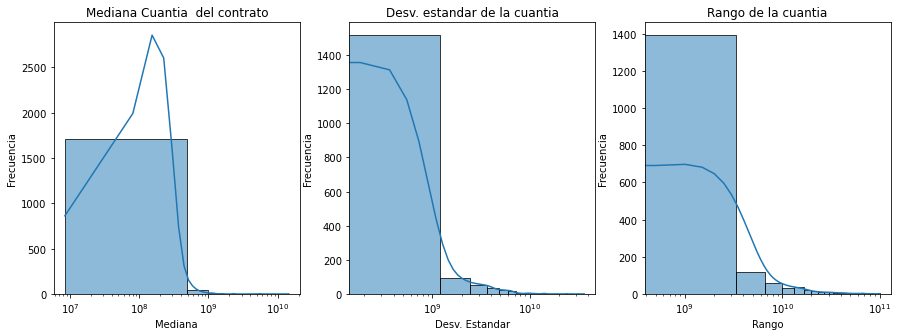

In [29]:
# Revisar la distribución de la media de los contratos
fig, (ax1,ax2,ax3) = plt.subplots(ncols=3, figsize=(15,5))

# Gráfico de la mediana
sns.histplot(data=ind_entidad, x="ind_ent_median_val", bins=30, kde=True, ax=ax1)
ax1.set_title("Mediana Cuantia  del contrato")
ax1.set_xlabel("Mediana")
ax1.set_xscale("log")
ax1.set_ylabel("Frecuencia")

# Gráfico de la desviación estandar de la cuantía
sns.histplot(data=ind_entidad, x="ind_ent_median_sd", bins=30, kde=True, ax=ax2)
ax2.set_title("Desv. estandar de la cuantia")
ax2.set_xlabel("Desv. Estandar")
ax2.set_xscale("log")
ax2.set_ylabel("Frecuencia")

# Gráfico del rango de la cuantía
sns.histplot(data=ind_entidad, x="ind_ent_median_rango", bins=30, kde=True, ax=ax3)
ax3.set_title("Rango de la cuantia")
ax3.set_xlabel("Rango")
ax3.set_xscale("log")
ax3.set_ylabel("Frecuencia")

#fig.savefig('plots/ind_ent_logestadisticas_contratos.png')
plt.show()

In [30]:
# Agregar orden de entidad, nivel entidad, departamento de la entidad
temp = (
    compras
    .groupby(["nombre_entidad","nivel_entidad","orden_entidad","departamento_entidad"])
    .size()
    .reset_index()
    .drop([0],axis=1)
    )
    
ind_entidad = integrar()

In [31]:
ind_entidad.rename({"nivel_entidad":'at_ent_nivel',
                    "orden_entidad":'at_ent_orden',
                    "departamento_entidad":'at_ent_dep'}, axis=1, inplace=True)

In [32]:
ind_entidad

,nombre_entidad,ind_ent_ncontratos,ind_ent_pcontr_directa_num,ind_ent_val_contratos,ind_ent_pcontr_directa_val,ind_ent_dif_pcontr_directa,ind_ent_HHI_num,ind_ent_HHI_val,ind_ent_dif_HHI,ind_ent_Idiversidad,ind_entidad_ncontratistas,ind_ent_ratio_contratistas,ind_ent_IC4K_num,ind_ent_IC4K_val,dif_IC4K,ind_ent_padicion_val,ind_ent_padicion_time,ind_ent_padicion_time_val,ind_ent_dif_adicion,ind_ent_median_val,ind_ent_median_sd,ind_ent_median_rango,at_ent_nivel,at_ent_orden,at_ent_dep
0,ADMINISTRADORA COLOMBIANA DE PENSIONES (COLPEN...,44,0.000000,212207960851,0.000000,0.000000,309.917355,1944.555768,-1634.638413,0.008457,37,0.840909,0.204545,0.807461,-0.602915,0.136364,0.113636,0.113636,-0.022727,322987080.5,1.340461e+10,65005563720,nacional,nac_descentralizado,bogotá-d.c.
1,AERONÁUTICA CIVIL (AEROCIVIL),332,0.054217,665733414599,0.058042,-0.003826,42.821890,273.814967,-230.993077,0.001274,278,0.837349,0.042169,0.272704,-0.230535,0.060241,0.111446,0.033133,0.051205,502185000.0,5.603356e+09,59982184671,nacional,nac_centralizado,bogotá-d.c.
2,AGENCIA DE DESARROLLO RURAL - ADR,5,0.200000,1542332558,0.100906,0.099094,2000.000000,3161.701982,-1161.701982,0.000000,5,1.000000,0.800000,0.928550,-0.128550,0.000000,0.400000,0.000000,0.400000,195185480.0,2.628424e+08,646116900,nacional,nac_descentralizado,bogotá-d.c.
3,AGENCIA DE RENOVACION DEL TERRITORIO,37,0.189189,22365554248,0.612546,-0.423357,372.534697,1664.513858,-1291.979161,0.010511,30,0.810811,0.216216,0.670363,-0.454146,0.081081,0.162162,0.081081,0.081081,250000000.0,1.109819e+09,6000000000,nacional,nac_centralizado,bogotá-d.c.
4,AGENCIA DEL INSPECTOR GENERAL DE TRIBUTOS REN...,16,0.250000,5376587591,0.420208,-0.170208,781.250000,1127.038439,-345.788439,0.016667,14,0.875000,0.375000,0.594263,-0.219263,0.125000,0.125000,0.062500,0.000000,199709329.5,2.881851e+08,959903886,nacional,nac_centralizado,bogotá-d.c.
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1764,VICHADA - ALCALDÍA MUNICIPIO DE CUMARIBO,57,0.105263,19595936839,0.077026,0.028237,360.110803,768.241445,-408.130642,0.018797,43,0.754386,0.245614,0.419270,-0.173656,0.087719,0.192982,0.017544,0.105263,206560000.0,5.952965e+08,4505968175,territorial,terri_distr_4,vichada
1765,VICHADA - ALCALDÍA MUNICIPIO DE LA PRIMAVERA,11,0.181818,2701338661,0.094392,0.087426,1404.958678,2323.250846,-918.292168,0.054545,8,0.727273,0.636364,0.773213,-0.136850,0.000000,0.000000,0.000000,0.000000,156689500.0,2.949346e+08,1024903677,territorial,terri_distr_6,vichada
1766,VICHADA - ALCALDÍA MUNICIPIO DE PUERTO CARREÑO,27,0.111111,5285021135,0.115307,-0.004196,644.718793,739.442883,-94.724090,0.028490,21,0.777778,0.370370,0.449020,-0.078650,0.000000,0.037037,0.000000,0.037037,153120000.0,1.198243e+08,479083100,territorial,terri_distr_4,vichada
1767,VICHADA - GOBERNACIÓN,79,0.037975,74420870784,0.104647,-0.066672,232.334562,764.083900,-531.749338,0.010711,56,0.708861,0.164557,0.477706,-0.313149,0.101266,0.240506,0.075949,0.139241,303000000.0,1.767766e+09,10628991538,territorial,terri_dep_no_centr,vichada


In [33]:
print('Se tienen un total de {} indicadores por entidad'.format(ind_entidad.shape[1] - 1))

Se tienen un total de 24 indicadores por entidad


In [34]:
guardar_indicadores_entidad = True
if guardar_indicadores_entidad:
    ind_entidad.to_csv('Datos/indicadores_contratacion_entidad.csv', index=False)

# Atributos del contrato

Atributos pendientes de construir:

- [] Agrupar los objetos a contratar (*objeto_contratar*) basado usando aprendizaje no supervisado
- [X] Extraer el mes de la firma del contrato (*fecha_firma_contrato*)
- [X] Extraer el mes de inicio del contrato
- [X] Calcular la diferencia entre la fecha de inicio y la fecha de firma
- [X] Unificar el plazo de ejecución del contrato a días
- [X] Unificar la adición de los contratos a días
- [X] Calcular el ratio entre el valor del proceso y valor del contrato
- [] Generar marcadores de valores extremos registrados en el valor del contrato, adiciones en tiempo y valor, y plazos de ejecución del contrato, entre otros errores. Registrar marcadores para cualquier tipo de incosistencia en el contrato.
- [] Generar indicadores para las incosistencias de los contratos a nivel de entidad. Una medida de transparencia de la información.
- [] Numero de contratos del proceso
- [] Verificar si hay registros repetidos
- [] Unificar la cuantia del contrato a pesos
- [] Integrar una probabilidad de que el contrato contenga error en el valor o la adición
- [] Incluir el tamaño de la población donde se encuentra la entidad
- [] Indicar si es ciudad capital o no.

In [35]:
# Seleccionar los atributos originales del contrato
contratos = compras[['id_contrato',
                     'nombre_entidad',
                     'tipo_proceso',
                     'cuantia_proceso', 
                     'nombre_grupo', 
                     'dpto_mcpo_contratista',
                     'fecha_firma_contrato',
                     'fecha_inicio_ejec_contrato', 
                     'plazo_ejec_contrato',
                     'rango_ejec_contrato', 
                     'tiempo_adiciones_dias',
                     'tiempo_adiciones_meses', 
                     'cuantia_contrato',
                     'valor_adiciones', 
                     'moneda', 
                     'municipio_entidad',
                     'dep_codigo_divipola',
                     'municipio_codigo_divipola', 
                     'id_contratista']].copy()

## Analizar cuantia de procesos y contratos

In [36]:
# Discretizar valores de contratos
cuts = 10**np.linspace(6,11,6)
cuts_name = ["mas de 1 millón", "mas de 10 millones", "mas de 100 millones", "mas de 1,000 millones", "mas de 10,000 millones"]
contratos["rango_cuantia"] = pd.cut(x=contratos["cuantia_contrato"], bins=cuts, labels=cuts_name) 
contratos["rango_cuantia"].value_counts(sort=False)

mas de 1 millón            2508
mas de 10 millones        12662
mas de 100 millones       68481
mas de 1,000 millones      7646
mas de 10,000 millones      716
Name: rango_cuantia, dtype: int64

In [37]:
# Ratio entre la cuantia del proceso y la cuantia del contrato
contratos["ratio_cuantia_contrato_proceso"] = contratos["cuantia_contrato"]/contratos["cuantia_proceso"]

In [38]:
#  Numero de contratos donde el ratio da indeterminado
sum(contratos["ratio_cuantia_contrato_proceso"] == np.infty)

40

In [39]:
# Reemplazar el indeterminado por 1, asumiendo que no precio base
# Entonces el valor del proceso es el mismo valor del contrato
contratos.loc[contratos["ratio_cuantia_contrato_proceso"] == np.infty, ['ratio_cuantia_proceso_contrato']] = 1

In [40]:
# Crear una variable que indique si se declara precio base
contratos['fija_precio_base'] = contratos['cuantia_proceso'] <= 0

In [41]:
# Porcentaje de contratos sin precio base
print('El porcentaje de contratos sin precio base es {:.4f} %'.format(np.mean(contratos['fija_precio_base'])*100))


El porcentaje de contratos sin precio base es 0.0452 %


In [42]:
contratos['fija_precio_base'].value_counts()

False    92855
True        42
Name: fija_precio_base, dtype: int64

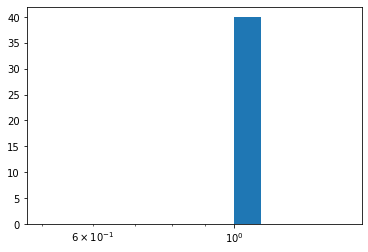

In [43]:
plt.hist(contratos["ratio_cuantia_proceso_contrato"])
plt.xscale('log')

## Procesar las fechas del contrato

- Firma
- Inicio ejecución

In [44]:
# Extraer el mes de la fecha de firma del contrato
contratos["mes_firma"] = pd.to_datetime(contratos["fecha_firma_contrato"]).dt.month_name()
contratos.groupby(["mes_firma"]).size()

mes_firma
April         7403
August        7226
December     13607
February      5211
January       5106
July          7791
June          7521
March         7141
May           7592
November      8704
October       8104
September     7491
dtype: int64

In [45]:
# Extraer el mes de inicio del contrato
contratos["mes_inicio"] = pd.to_datetime(contratos["fecha_inicio_ejec_contrato"]).dt.month_name()
contratos["mes_inicio"].value_counts()

December     13800
November      8594
October       7988
July          7860
May           7509
September     7444
June          7380
August        7302
April         7291
March         6740
January       5648
February      5341
Name: mes_inicio, dtype: int64

In [46]:
# Extraer el mes de la fecha de firma del contrato
contratos["mes_firma"] = pd.to_datetime(contratos["fecha_firma_contrato"]).dt.month_name()
contratos.groupby(["mes_firma"]).size()

mes_firma
April         7403
August        7226
December     13607
February      5211
January       5106
July          7791
June          7521
March         7141
May           7592
November      8704
October       8104
September     7491
dtype: int64

In [47]:
contratos["dif_inicio_firma"] = pd.to_datetime(contratos["fecha_inicio_ejec_contrato"]) - pd.to_datetime(contratos["fecha_firma_contrato"])
contratos["dif_inicio_firma"] = contratos["dif_inicio_firma"].dt.days
contratos["dif_inicio_firma"].describe()

count    92897.000000
mean         5.491265
std         38.562948
min      -4381.000000
25%          0.000000
50%          2.000000
75%          7.000000
max       2194.000000
Name: dif_inicio_firma, dtype: float64

In [48]:
# Posibles errores en la fecha de inicio o firma
print("Hay {:,} contratos con fecha de inicio previo a la fecha de firma".format(sum(contratos["dif_inicio_firma"] < 0)))
print("Hay {:,} contratos con fecha de inicio despues de 90 días a la fecha de firma".format(sum(contratos["dif_inicio_firma"] > 90)))
print("Hay {:,} contratos con fecha de inicio despues de 180 días a la fecha de firma".format(sum(contratos["dif_inicio_firma"] > 180)))
print("Hay {:,} contratos con fecha de inicio despues de 360 días a la fecha de firma".format(sum(contratos["dif_inicio_firma"] > 360)))

Hay 1,195 contratos con fecha de inicio previo a la fecha de firma
Hay 594 contratos con fecha de inicio despues de 90 días a la fecha de firma
Hay 287 contratos con fecha de inicio despues de 180 días a la fecha de firma
Hay 177 contratos con fecha de inicio despues de 360 días a la fecha de firma


## Limpizar los plazos de ejecución del contrato y las adiciones en tiempo

In [49]:
# Unificar el plazo de ejecución a dias
contratos['rango_ejec_contrato'].value_counts()

D    52930
M    39740
N      227
Name: rango_ejec_contrato, dtype: int64

In [50]:
# Contratos de mas de 60 meses (5 años), su duración se deja en días.
contratos.loc[(contratos['rango_ejec_contrato'] ==  "M") & (contratos['plazo_ejec_contrato'] >  60), ['rango_ejec_contrato']] = "D"

# Transformar el plazo de ejecución del contrato de meses a días
contratos.loc[contratos['rango_ejec_contrato'] ==  "M", ['plazo_ejec_contrato']] = contratos.loc[contratos['rango_ejec_contrato'] ==  "M", ['plazo_ejec_contrato']]*30

# Ajustar los valores extremos (mas de 1825 días o 5 años, cada año de 365) a la mediana
contratos.loc[contratos["plazo_ejec_contrato"] > 1825, ["plazo_ejec_contrato"]] = np.median(contratos.loc[contratos["plazo_ejec_contrato"] <= 1825, ["plazo_ejec_contrato"]])

# Eliminar la columna rango de ejecución del contrato
contratos.drop(columns=['rango_ejec_contrato'], inplace=True)

contratos["plazo_ejec_contrato"].describe()

count    92897.000000
mean       126.296565
std        141.570816
min          0.000000
25%         30.000000
50%         90.000000
75%        180.000000
max       1825.000000
Name: plazo_ejec_contrato, dtype: float64

In [51]:
# Unificar el tiempo de adición
contratos["tiempo_adiciones"] = contratos["tiempo_adiciones_dias"] + contratos["tiempo_adiciones_meses"]*30

# Hay contratos donde al parecer se registra el tiempo de adición tanto en días como en meses
# Para este caso se deja uno de los dos
contratos.loc[(contratos['tiempo_adiciones_dias'] > 0) & (contratos['tiempo_adiciones_dias']/30 == contratos['tiempo_adiciones_meses'])]

,id_contrato,nombre_entidad,tipo_proceso,cuantia_proceso,nombre_grupo,dpto_mcpo_contratista,fecha_firma_contrato,fecha_inicio_ejec_contrato,plazo_ejec_contrato,tiempo_adiciones_dias,tiempo_adiciones_meses,cuantia_contrato,valor_adiciones,moneda,municipio_entidad,dep_codigo_divipola,municipio_codigo_divipola,id_contratista,rango_cuantia,ratio_cuantia_contrato_proceso,ratio_cuantia_proceso_contrato,fija_precio_base,mes_firma,mes_inicio,dif_inicio_firma,tiempo_adiciones
1001,16-9-416651-4864826,DIRECCIÓN GENERAL DE LA POLICÍA NACIONAL (PONAL),subasta,104696316,[E] Productos de Uso Final,Bogotá D.C.,07/11/2016,07/18/2016,240,30,1,104696316,0,Pesos (COP),BOGOTÁ D.C.,11000,11001,900.202.290-1,mas de 100 millones,1.000000,NaN,False,July,July,7,60
5966,16-9-425182-5709176,BOGOTÁ D.C. - SECRETARÍA DE INTEGRACIÓN SOCIAL,subasta,1261310389,[E] Productos de Uso Final,Bogotá D.C.,02/27/2017,03/03/2017,60,60,2,1261310389,628062106,Pesos (COP),BOGOTÁ D.C.,11000,11001,830001338,"mas de 1,000 millones",1.000000,NaN,False,February,March,4,120
8539,19-4-9170098-8589876,BOGOTÁ D.C.-SUBRED INTEGRADA SERVICIOS DE SALU...,regimen_especial,2840000000,[E] Productos de Uso Final,Bogotá D.C.,05/07/2019,05/07/2019,60,30,1,36667400,55001100,Pesos (COP),BOGOTÁ D.C.,11000,11001,800090902,mas de 10 millones,0.012911,NaN,False,May,May,0,60
9111,11-9-217304-503842,INSTITUTO DE CASAS FISCALES DEL EJÉRCITO (ICFE),subasta,500000000,[F] Servicios,Bogotá D.C.,02/28/2011,03/01/2011,300,60,2,455380000,182152000,Pesos (COP),BOGOTÁ D.C.,11000,11001,800148041-0,mas de 100 millones,0.910760,NaN,False,February,March,1,120
11595,18-4-7948025-7219490,QUINDÍO - HOSPITAL DEPARTAMENTAL UNIVERSITARIO...,regimen_especial,140000000,[F] Servicios,Quindío,03/13/2018,02/13/2018,210,30,1,140000000,7000000,Pesos (COP),ARMENIA,63000,63001,830091676,mas de 100 millones,1.000000,NaN,False,March,February,-28,60
14729,11-9-312089-687986,DIRECCIÓN GENERAL DE LA POLICÍA NACIONAL (PONAL),subasta,167000000,[B] Materias Primas,Bogotá D.C.,10/26/2011,11/04/2011,148,60,2,167000000,0,Pesos (COP),BOGOTÁ D.C.,11000,11001,860.040.094-3,mas de 100 millones,1.000000,NaN,False,October,November,9,120
17605,16-11-5662941-5326409,DIRECCIÓN GENERAL MARÍTIMA,seleccion_abreviada,156674555,[F] Servicios,Atlántico,11/25/2016,12/01/2016,330,30,1,143076965,68389813,Pesos (COP),BOGOTÁ D.C.,11000,11001,900091901,mas de 100 millones,0.913211,NaN,False,November,December,6,60
17675,14-4-2974617-2787535,BOGOTÁ D.C. - E.S.E. HOSPITAL SANTA CLARA III ...,regimen_especial,120000000,[E] Productos de Uso Final,Bogotá D.C.,09/16/2014,09/19/2014,60,60,2,120000000,120000000,Pesos (COP),BOGOTÁ D.C.,11000,11001,890300292-0,mas de 100 millones,1.000000,NaN,False,September,September,3,120
19986,12-11-882866-915610,DIRECCIÓN GENERAL DE LA POLICÍA NACIONAL (PONAL),seleccion_abreviada,450000000,[E] Productos de Uso Final,Bogotá D.C.,05/29/2012,05/29/2012,270,60,2,18439872,79573848,Pesos (COP),BOGOTÁ D.C.,11000,11001,830143035-2,mas de 10 millones,0.040977,NaN,False,May,May,0,120
21047,18-4-7954741-7226845,NORTE DE SANTANDER - E.S.E. HOSPITAL UNIVERSIT...,regimen_especial,200000000,[F] Servicios,Norte De Santander,03/12/2018,03/12/2018,30,30,1,200000000,100000000,Pesos (COP),SAN JOSÉ DE CÚCUTA,54000,54001,900371464,mas de 100 millones,1.000000,NaN,False,March,March,0,60


In [52]:
# Asignar el tiempo
contratos.loc[(contratos['tiempo_adiciones_dias'] > 0) & (contratos['tiempo_adiciones_dias']/30 == contratos['tiempo_adiciones_meses']), 'tiempo_adiciones'] = contratos.loc[(contratos['tiempo_adiciones_dias'] > 0) & (contratos['tiempo_adiciones_dias']/30 == contratos['tiempo_adiciones_meses']), 'tiempo_adiciones_dias'] 

In [53]:
contratos['tiempo_adiciones_dias'] = contratos['tiempo_adiciones']

# Ajustar valores extremos adiciones en tiempo de mas de 1825 días
contratos.loc[contratos["tiempo_adiciones_dias"] > 1825, ["tiempo_adiciones_dias"]] = np.median(contratos.loc[contratos["tiempo_adiciones_dias"] <= 1825, ["tiempo_adiciones_dias"]])

# Eliminar la columna tiempo de adiciones en meses y tiempo adiciones
contratos.drop(columns=["tiempo_adiciones_meses","tiempo_adiciones"], inplace=True)

# Ajustar las adiciones en tiempo con valores extremos sumado ejecución + duración mas de 1825 dias
contratos["tiempo_total"] = contratos["plazo_ejec_contrato"] + contratos["tiempo_adiciones_dias"]
contratos["tiempo_total"].describe()

count    92897.000000
mean       141.014145
std        157.574563
min          0.000000
25%         31.000000
50%         90.000000
75%        210.000000
max       2340.000000
Name: tiempo_total, dtype: float64

<AxesSubplot:xlabel='tiempo_total_rango'>

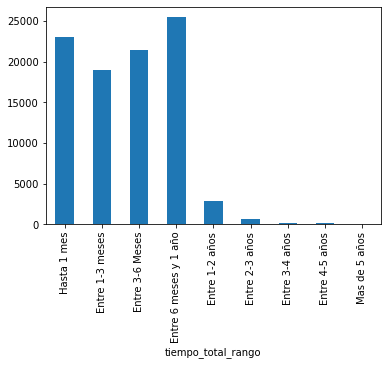

In [54]:
# Discretizar la duración total de los contratos
cuts_tiempo_total = [0, 30, 89, 179, 365, 730, 1095, 1460, 1826, np.max(contratos["tiempo_total"])]
names_cuts_tiempo = ["Hasta 1 mes", "Entre 1-3 meses", "Entre 3-6 Meses","Entre 6 meses y 1 año",
                     "Entre 1-2 años", "Entre 2-3 años", "Entre 3-4 años", "Entre 4-5 años", "Mas de 5 años"]
contratos["tiempo_total_rango"] = pd.cut(x=contratos["tiempo_total"], bins=cuts_tiempo_total, labels=names_cuts_tiempo)
contratos.groupby(["tiempo_total_rango"]).size().plot(kind="bar")

In [55]:
# Valor de los contratos de acuerdo a la duración
contratos.groupby(["tiempo_total_rango"])["cuantia_contrato"].mean()

tiempo_total_rango
Hasta 1 mes              3.880526e+08
Entre 1-3 meses          4.510988e+08
Entre 3-6 Meses          5.840543e+08
Entre 6 meses y 1 año    7.123775e+08
Entre 1-2 años           1.915880e+09
Entre 2-3 años           2.674934e+09
Entre 3-4 años           2.028819e+09
Entre 4-5 años           3.957261e+09
Mas de 5 años            2.981645e+09
Name: cuantia_contrato, dtype: float64

## Análisis del tipo de moneda

In [56]:
contratos["moneda"].value_counts()

Pesos (COP)      91851
Dólares (USD)      953
No Definida         93
Name: moneda, dtype: int64

In [57]:
contratos.loc[contratos["moneda"] == "Dólares (USD)", ["cuantia_contrato"]].describe()

,cuantia_contrato
count,9.530000e+02
mean,1.170512e+09
std,3.841902e+09
min,0.000000e+00
25%,8.919460e+05
50%,2.149140e+08
75%,8.093184e+08
max,5.635937e+10


## Renombrar columnas

In [58]:

colnames = {i:'at_con_' + i for i in contratos.columns if i != 'nombre_entidad'}
contratos.rename(colnames, axis=1, inplace=True)

In [59]:
contratos

,at_con_id_contrato,nombre_entidad,at_con_tipo_proceso,at_con_cuantia_proceso,at_con_nombre_grupo,at_con_dpto_mcpo_contratista,at_con_fecha_firma_contrato,at_con_fecha_inicio_ejec_contrato,at_con_plazo_ejec_contrato,at_con_tiempo_adiciones_dias,at_con_cuantia_contrato,at_con_valor_adiciones,at_con_moneda,at_con_municipio_entidad,at_con_dep_codigo_divipola,at_con_municipio_codigo_divipola,at_con_id_contratista,at_con_rango_cuantia,at_con_ratio_cuantia_contrato_proceso,at_con_ratio_cuantia_proceso_contrato,at_con_fija_precio_base,at_con_mes_firma,at_con_mes_inicio,at_con_dif_inicio_firma,at_con_tiempo_total,at_con_tiempo_total_rango
0,19-4-8936247-8445914,BOGOTÁ D.C. - E.S.E. HOSPITAL UNIVERSITARIO DE...,regimen_especial,6427018959,[E] Productos de Uso Final,Bogotá D.C.,04/08/2019,04/08/2019,240,98,116956599,58478010,Pesos (COP),BOGOTÁ D.C.,11000,11001,828002423,mas de 100 millones,0.018198,NaN,False,April,April,0,338,Entre 6 meses y 1 año
1,17-4-7309977-6639778,ECOPETROL - EMPRESA COLOMBIANA DE PETRÓLEOS,regimen_especial,478846774,"[C] Maquinaria, Herramientas, Equipo Industria...",Bogotá D.C.,11/08/2017,11/08/2017,30,0,478846774,0,Pesos (COP),BOGOTÁ D.C.,11000,11001,900310458,mas de 100 millones,1.000000,NaN,False,November,November,0,30,Hasta 1 mes
2,18-4-7832792-7109662,CALDAS - HOSPITAL DEPARTAMENTAL SANTA SOFIA DE...,regimen_especial,284000000,[E] Productos de Uso Final,Bogotá D.C.,02/01/2018,02/01/2018,61,0,283771000,0,Pesos (COP),MANIZALES,17000,17001,860026442,mas de 100 millones,0.999194,NaN,False,February,February,0,61,Entre 1-3 meses
3,17-11-6315112-5886490,CORMACARENA - CORPORACIÓN PARA EL DESARROLLO S...,seleccion_abreviada,144000000,[B] Materias Primas,Córdoba,04/08/2017,04/08/2017,360,0,144000000,60000000,Pesos (COP),VILLAVICENCIO,50000,50001,811009788,mas de 100 millones,1.000000,NaN,False,April,April,0,360,Entre 6 meses y 1 año
4,11-11-555913-673268,EJÉRCITO NACIONAL,seleccion_abreviada,114062800,[E] Productos de Uso Final,La Guajira,08/25/2011,08/25/2011,60,0,114082800,0,Pesos (COP),BOGOTÁ D.C.,11000,11001,66856284-9,mas de 100 millones,1.000175,NaN,False,August,August,0,60,Entre 1-3 meses
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92892,17-11-6848724-6340714,SERVICIO NACIONAL DE APRENDIZAJE (SENA),seleccion_abreviada,399999431,"[C] Maquinaria, Herramientas, Equipo Industria...",Bogotá D.C.,08/24/2017,08/24/2017,90,0,396412800,0,Pesos (COP),BOGOTÁ D.C.,11000,11001,9006131082,mas de 100 millones,0.991033,NaN,False,August,August,0,90,Entre 3-6 Meses
92893,17-12-6341378-5767593,NARIÑO - ALCALDÍA MUNICIPIO DE OSPINA,contratacion_directa,134000000,"[G] Terrenos, Edificios, Estructuras y vías",Nariño,03/09/2017,03/10/2017,20,0,134000000,0,Pesos (COP),OSPINA,52000,52506,27373964,mas de 100 millones,1.000000,NaN,False,March,March,1,20,Hasta 1 mes
92894,11-1-72828-741573,INSTITUTO NACIONAL DE MEDICINA LEGAL Y CIENCIA...,licitacion_publica,297091007,[B] Materias Primas,Bogotá D.C.,12/07/2011,12/15/2011,6,57,6776047,0,Pesos (COP),BOGOTÁ D.C.,11000,11001,860501595 - 0,mas de 1 millón,0.022808,NaN,False,December,December,8,63,Entre 1-3 meses
92895,19-9-460791-9242959,SERVICIO NACIONAL DE APRENDIZAJE (SENA),subasta,192719209,[D] Componentes y Suministros,Huila,11/22/2019,11/25/2019,15,53,190796602,0,Pesos (COP),BOGOTÁ D.C.,11000,11001,7694923,mas de 100 millones,0.990024,NaN,False,November,November,3,68,Entre 1-3 meses


In [60]:
guardar_contratos_compras = False
if guardar_contratos_compras:
    contratos.to_csv('Datos/atributos_contratos_compras.csv', index=False)

## Integrar atributos de contratos e indicadores de riesgo

Los atributos del contrato y los indicadores de riesgo se integran en una tabla maestra.

In [61]:
# Integrar las bases de datos
tabla_maestra = pd.merge(left=contratos, 
                right=ind_entidad, 
                how="left",
                on='nombre_entidad')

In [62]:
# Información de la tabla maestra
tabla_maestra.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 92929 entries, 0 to 92928
Data columns (total 50 columns):
 #   Column                                 Non-Null Count  Dtype   
---  ------                                 --------------  -----   
 0   at_con_id_contrato                     92929 non-null  object  
 1   nombre_entidad                         92929 non-null  object  
 2   at_con_tipo_proceso                    92929 non-null  object  
 3   at_con_cuantia_proceso                 92929 non-null  int64   
 4   at_con_nombre_grupo                    92929 non-null  object  
 5   at_con_dpto_mcpo_contratista           92929 non-null  object  
 6   at_con_fecha_firma_contrato            92929 non-null  object  
 7   at_con_fecha_inicio_ejec_contrato      92929 non-null  object  
 8   at_con_plazo_ejec_contrato             92929 non-null  int64   
 9   at_con_tiempo_adiciones_dias           92929 non-null  int64   
 10  at_con_cuantia_contrato                92929 non-null  int

In [63]:
# Vista previa de la tabla maestra
tabla_maestra.head(10)

,at_con_id_contrato,nombre_entidad,at_con_tipo_proceso,at_con_cuantia_proceso,at_con_nombre_grupo,at_con_dpto_mcpo_contratista,at_con_fecha_firma_contrato,at_con_fecha_inicio_ejec_contrato,at_con_plazo_ejec_contrato,at_con_tiempo_adiciones_dias,at_con_cuantia_contrato,at_con_valor_adiciones,at_con_moneda,at_con_municipio_entidad,at_con_dep_codigo_divipola,at_con_municipio_codigo_divipola,at_con_id_contratista,at_con_rango_cuantia,at_con_ratio_cuantia_contrato_proceso,at_con_ratio_cuantia_proceso_contrato,at_con_fija_precio_base,at_con_mes_firma,at_con_mes_inicio,at_con_dif_inicio_firma,at_con_tiempo_total,at_con_tiempo_total_rango,ind_ent_ncontratos,ind_ent_pcontr_directa_num,ind_ent_val_contratos,ind_ent_pcontr_directa_val,ind_ent_dif_pcontr_directa,ind_ent_HHI_num,ind_ent_HHI_val,ind_ent_dif_HHI,ind_ent_Idiversidad,ind_entidad_ncontratistas,ind_ent_ratio_contratistas,ind_ent_IC4K_num,ind_ent_IC4K_val,dif_IC4K,ind_ent_padicion_val,ind_ent_padicion_time,ind_ent_padicion_time_val,ind_ent_dif_adicion,ind_ent_median_val,ind_ent_median_sd,ind_ent_median_rango,at_ent_nivel,at_ent_orden,at_ent_dep
0,19-4-8936247-8445914,BOGOTÁ D.C. - E.S.E. HOSPITAL UNIVERSITARIO DE...,regimen_especial,6427018959,[E] Productos de Uso Final,Bogotá D.C.,04/08/2019,04/08/2019,240,98,116956599,58478010,Pesos (COP),BOGOTÁ D.C.,11000,11001,828002423,mas de 100 millones,0.018198,NaN,False,April,April,0,338,Entre 6 meses y 1 año,1740,0.000000,208381447360,0.000000,0.000000,43.202537,107.519373,-64.316836,0.003748,700,0.402299,0.062069,0.144813,-0.082744,0.290805,0.222989,0.127011,-0.067816,35064554.0,3.462563e+08,8300238195,territorial,terri_dep_no_centr,bogotá-d.c.
1,17-4-7309977-6639778,ECOPETROL - EMPRESA COLOMBIANA DE PETRÓLEOS,regimen_especial,478846774,"[C] Maquinaria, Herramientas, Equipo Industria...",Bogotá D.C.,11/08/2017,11/08/2017,30,0,478846774,0,Pesos (COP),BOGOTÁ D.C.,11000,11001,900310458,mas de 100 millones,1.000000,NaN,False,November,November,0,30,Hasta 1 mes,4773,0.000838,4119679980677,0.000972,-0.000134,47.920840,78.745464,-30.824624,0.004584,1611,0.337524,0.098261,0.105590,-0.007329,0.004190,0.023884,0.003352,0.019694,232775861.0,3.276413e+09,64351238128,nacional,nac_centralizado,bogotá-d.c.
2,18-4-7832792-7109662,CALDAS - HOSPITAL DEPARTAMENTAL SANTA SOFIA DE...,regimen_especial,284000000,[E] Productos de Uso Final,Bogotá D.C.,02/01/2018,02/01/2018,61,0,283771000,0,Pesos (COP),MANIZALES,17000,17001,860026442,mas de 100 millones,0.999194,NaN,False,February,February,0,61,Entre 1-3 meses,365,0.000000,86958962003,0.000000,0.000000,189.829236,313.849627,-124.020391,0.016288,109,0.298630,0.172603,0.257819,-0.085216,0.221918,0.071233,0.016438,-0.150685,148000000.0,3.417861e+08,2948941289,territorial,terri_dep_centr,caldas
3,17-11-6315112-5886490,CORMACARENA - CORPORACIÓN PARA EL DESARROLLO S...,seleccion_abreviada,144000000,[B] Materias Primas,Córdoba,04/08/2017,04/08/2017,360,0,144000000,60000000,Pesos (COP),VILLAVICENCIO,50000,50001,811009788,mas de 100 millones,1.000000,NaN,False,April,April,0,360,Entre 6 meses y 1 año,20,0.000000,8304075687,0.000000,0.000000,750.000000,1418.885094,-668.885094,0.026316,16,0.800000,0.400000,0.707217,-0.307217,0.350000,0.450000,0.250000,0.100000,151786307.5,4.722057e+08,1396854340,nacional,nac_centralizado,meta
4,11-11-555913-673268,EJÉRCITO NACIONAL,seleccion_abreviada,114062800,[E] Productos de Uso Final,La Guajira,08/25/2011,08/25/2011,60,0,114082800,0,Pesos (COP),BOGOTÁ D.C.,11000,11001,66856284-9,mas de 100 millones,1.000175,NaN,False,August,August,0,60,Entre 1-3 meses,3286,0.086427,2911233231373,0.313571,-0.227144,14.732636,116.674450,-101.941814,0.001169,1990,0.605600,0.045344,0.157360,-0.112016,0.136336,0.053865,0.031649,-0.082471,219583528.0,4.006596e+09,100000000000,nacional,nac_centralizado,bogotá-d.c.
5,18-9-451181-8564969,TOLIMA - ALCALDÍA MUNICIPIO DE ICONONZO,subasta,146099384,[D] Componentes y Suministros,Tolima,12/17/2018,12/17/2018,10,0,145914825,0,Pesos (COP),ICONONZO,73000,73352,111006055

In [64]:
tabla_maestra["adicion"] = np.where(((tabla_maestra["at_con_valor_adiciones"] > 0 )| (tabla_maestra["at_con_tiempo_adiciones_dias"] > 0)), 1, 0)
#tabla_maestra.drop(columns=["at_con_valor_adiciones","at_con_tiempo_adiciones_dias"], inplace=True)
tabla_maestra["adicion"].value_counts()

0    69792
1    23137
Name: adicion, dtype: int64

In [65]:
guardar_tabla_maestra = False
if guardar_tabla_maestra:
    tabla_maestra.to_csv('Datos/tabla_maestra_compras.csv', index=False)

# Análisis Exploratorio de Datos

In [66]:
def perc_class(df):
    p = df['adicion'].value_counts()
    p = p/np.sum(p)
    return p

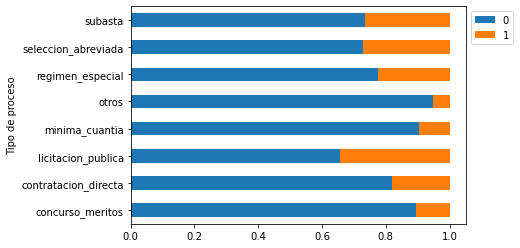

In [67]:
# Proporción de contratos con adiciones por tipo de proceso
tabla_maestra.groupby(['at_con_tipo_proceso']).apply(perc_class).plot(kind='barh', stacked=True)
plt.ylabel('Tipo de proceso')
plt.legend(bbox_to_anchor=(1.0, 1.0))
plt.show()

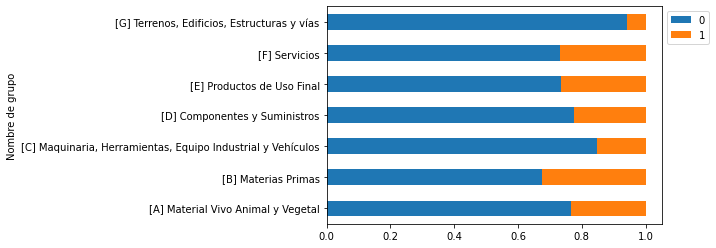

In [68]:
tabla_maestra.groupby(['at_con_nombre_grupo']).apply(perc_class).plot(kind='barh', stacked=True)
plt.ylabel('Nombre de grupo')
plt.legend(bbox_to_anchor=(1.0, 1.0))
plt.show()

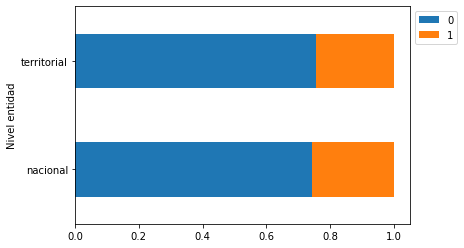

In [69]:
tabla_maestra.groupby(['at_ent_nivel']).apply(perc_class).plot(kind='barh', stacked=True)
plt.ylabel('Nivel entidad')
plt.legend(bbox_to_anchor=(1.0, 1.0))
plt.show()

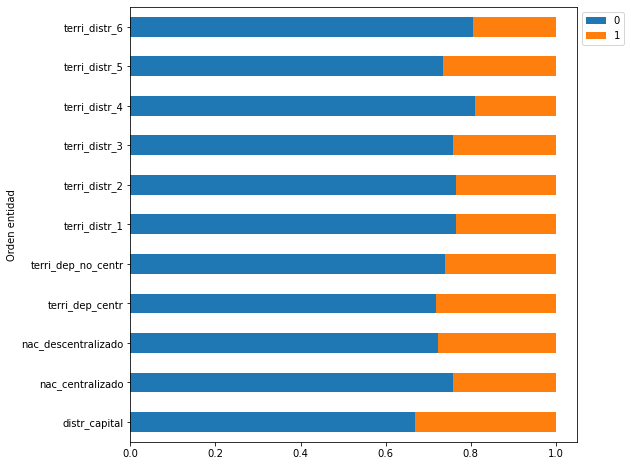

In [70]:
tabla_maestra.groupby(['at_ent_orden']).apply(perc_class).plot(kind='barh', stacked=True, figsize=(8,8))
plt.ylabel('Orden entidad')
plt.legend(bbox_to_anchor=(1.0, 1.0))
plt.show()

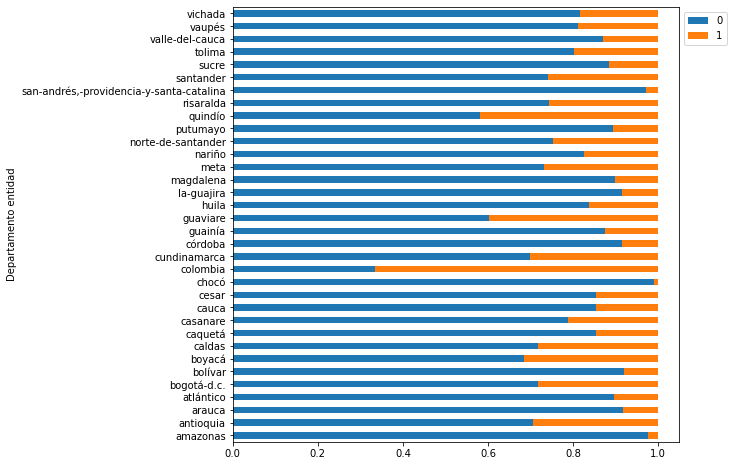

In [71]:
tabla_maestra.groupby(['at_ent_dep']).apply(perc_class).unstack().plot(kind='barh', stacked=True, figsize=(8,8))
plt.ylabel('Departamento entidad')
plt.legend(bbox_to_anchor=(1.0, 1.0))
plt.show()

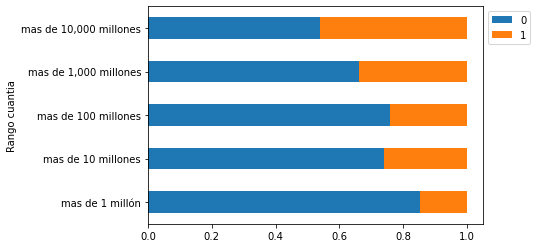

In [72]:
tabla_maestra.groupby(['at_con_rango_cuantia']).apply(perc_class).plot(kind='barh', stacked=True)
plt.ylabel('Rango cuantia')
plt.legend(bbox_to_anchor=(1.0, 1.0))
plt.show()

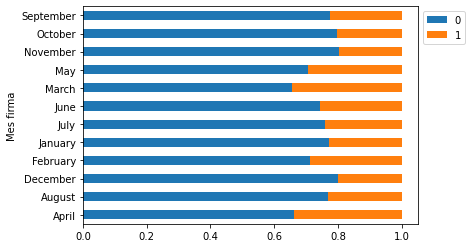

In [73]:
tabla_maestra.groupby(['at_con_mes_firma']).apply(perc_class).plot(kind='barh', stacked=True)
plt.ylabel('Mes firma')
plt.legend(bbox_to_anchor=(1.0, 1.0))
plt.show()

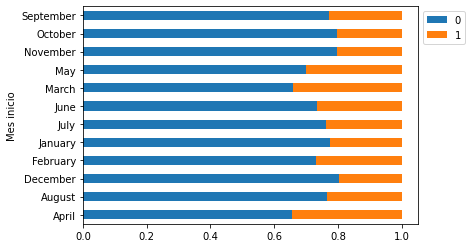

In [74]:
tabla_maestra.groupby(['at_con_mes_inicio']).apply(perc_class).plot(kind='barh', stacked=True)
plt.ylabel('Mes inicio')
plt.legend(bbox_to_anchor=(1.0, 1.0))
plt.show()

## Análisis de variables numericas

In [75]:
# Función para desarrollar la prueba de Mann-Whitney para comparar si hay diferencia del valor 
def man_whit_test(data=tbm, cat_var='adicion', num_var=None):
    Y1 = np.array(data.loc[df[cat_var] == 1, [num_var]]) 
    Y0 = np.array(data.loc[df[cat_var] == 0, [num_var]])
    U_test, valor_p = scipy.stats.mannwhitneyu(Y1, Y0, alternative='two-sided')
    print('Valor p = {:.2e}'.format(valor_p) )
    return scipy.stats.mannwhitneyu(Y1, Y0, alternative='two-sided')

NameError: name 'tbm' is not defined

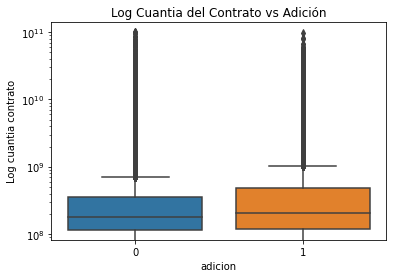

In [ ]:
#man_whit_test(data=tbm, cat_var='adicion', num_var='at_con_cuantia_contrato')
sns.boxplot(data=tabla_maestra, x='adicion', y='at_con_cuantia_contrato')
plt.ylabel('Log cuantia contrato')
plt.title('Log Cuantia del Contrato vs Adición')
plt.yscale('log')

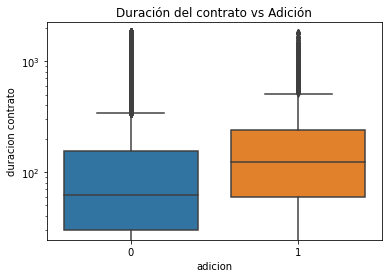

In [ ]:
#man_whit_test(data=df, cat_var='adicion', num_var='plazo_ejec_contrato')
sns.boxplot(data=tabla_maestra, x='adicion', y='at_con_plazo_ejec_contrato')
plt.title('Duración del contrato vs Adición')
plt.ylabel('duracion contrato')
plt.yscale('log')

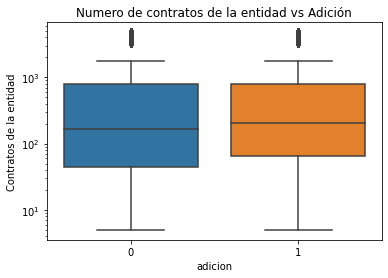

In [ ]:
# man_whit_test(data=df, cat_var='adicion', num_var='num_contratos_ent')
sns.boxplot(data=tabla_maestra, x='adicion', y='ind_ent_ncontratos')
plt.title('Numero de contratos de la entidad vs Adición')
plt.ylabel('Contratos de la entidad')
plt.yscale('log')

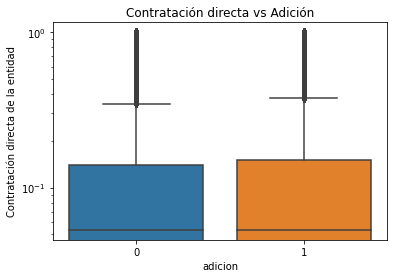

In [ ]:
#man_whit_test(data=df, cat_var='adicion', num_var='perc_contr_directa_num')
sns.boxplot(data=tabla_maestra, x='adicion', y='ind_ent_pcontr_directa_num')
plt.title('Contratación directa vs Adición')
plt.ylabel('Contratación directa de la entidad')
plt.yscale('log')

In [ ]:
# Conteo de variables categoricas
for col in tabla_maestra.select_dtypes(include=['category','object']).columns:
    if col != 'at_con_id_contrato':
        print("_"*50)
        print(col)
        print(tabla_maestra[col].value_counts()/tabla_maestra.shape[0])

__________________________________________________
nombre_entidad
ECOPETROL - EMPRESA COLOMBIANA DE PETRÓLEOS                                                         0.051362
SERVICIO NACIONAL DE APRENDIZAJE (SENA)                                                             0.047122
DIRECCIÓN GENERAL DE LA POLICÍA NACIONAL (PONAL)                                                    0.042452
EJÉRCITO NACIONAL                                                                                   0.035360
BOGOTÁ D.C. - E.S.E. HOSPITAL UNIVERSITARIO DE LA SAMARITANA                                        0.018724
                                                                                                      ...   
META - E.S.E HOSPITAL LOCAL DE SAN MARTÍN EMPRESA SOCIAL DEL MUNICIPIO- SAN MARTÍN DE LOS LLANOS    0.000054
CUNDINAMARCA - ALCALDÍA MUNICIPIO DE SAN ANTONIO DEL TEQUENDAMA                                     0.000054
BOYACÁ - ALCALDÍA MUNICIPIO DE NUEVO COLÓN                    